<a href="https://colab.research.google.com/github/JR-1991/Catalax/blob/master/examples/NonObservableSpecies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import catalax
except ImportError:
    !pip install git+https://github.com/JR-1991/Catalax.git

/Users/jara1991/anaconda3/envs/catalax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import jax
import numpy as np

from catalax import Model, visualize
from catalax.mcmc import run_mcmc, priors

jax.config.update("jax_enable_x64", True)

In [3]:
model = Model(name="Non-Observable Menten Inhibition")

# Another way of adding species (symbols and names at the same type)
model.add_species(
    s1="Substrate",
    e1="Enzyme",
)

# In this application 'e1' is not observable and thus
# 'k_d' needs to be inferred implicitly from the data.
model.add_ode("s1", "- e1 * k_cat * s1 / (s1 + K_m)")
model.add_ode("e1", "-k_d", observable=False)

model.parameters.K_m.value = 100.0
model.parameters.k_cat.value = 10.0
model.parameters.k_d.value = 0.0001

model

Model summary


Eq(x, Matrix([[s1, e1]]))

Eq(theta, Matrix([[K_m, k_cat, k_d]]))

Eq(Derivative(Substrate, t), -e1*k_cat*s1/(K_m + s1))

Eq(Derivative(Enzyme, t), -k_d)

,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,K_m,K_m,100.0000,False,None,None,None,None
1,k_cat,k_cat,10.0000,False,None,None,None,None
2,k_d,k_d,0.0001,False,None,None,None,None


In [4]:
# Create some dummy data to test
initial_conditions = [
    {"s1": 10.0, "e1": 0.1},
    {"s1": 50.0, "e1": 0.1},
    {"s1": 75.0, "e1": 0.1},
    {"s1": 100.0, "e1": 0.1},
    {"s1": 200.0, "e1": 0.1},
    {"s1": 300.0, "e1": 0.1},
    {"s1": 400.0, "e1": 0.1},
]

time, states = model.simulate(
    initial_conditions=initial_conditions,
    dt0=0.1, t0=0, t1=1000, nsteps=10, in_axes=(0, None, None),
)

# Add some noise to the data
states = (states + states * np.random.normal(0, 0.02)).clip(min=0)

# Truncate data to only include s1
data = states[:, :, 1]

print(f"Time: {time.shape} | Data: {data.shape}")

Time: (7, 10) | Data: (7, 10)


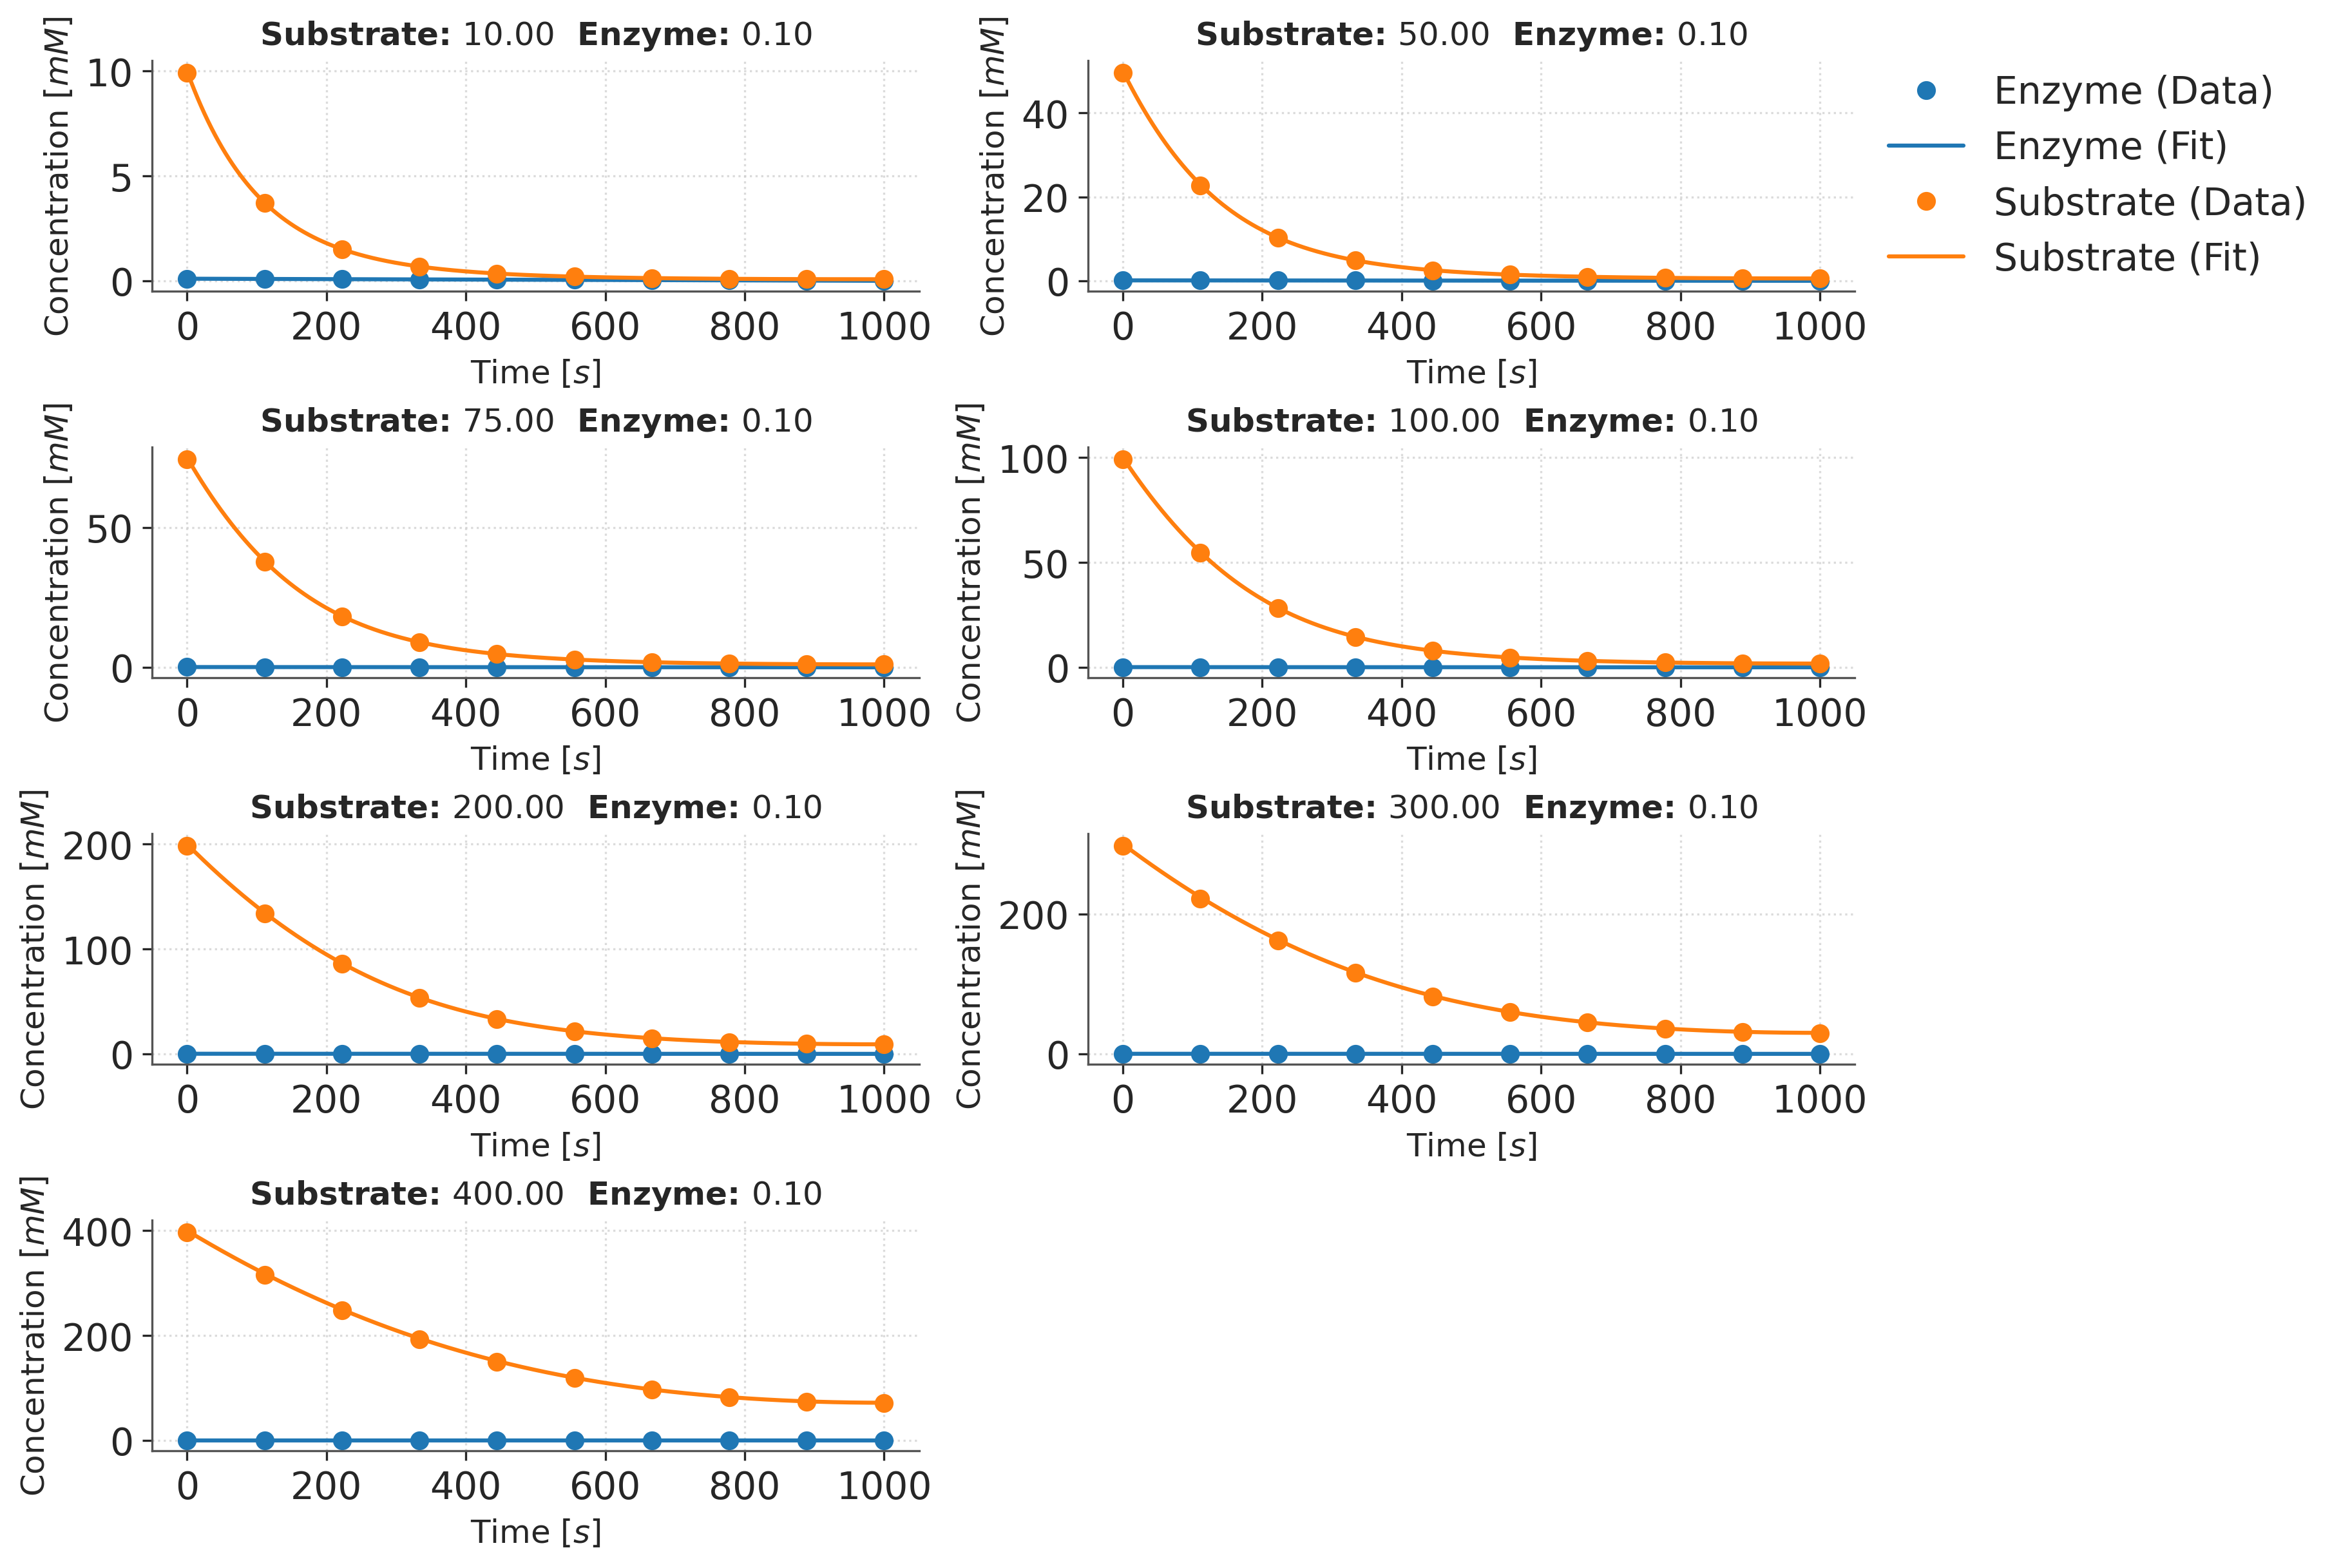

In [5]:
f = visualize(
    model=model,
    data=states,
    times=time,
    initial_conditions=initial_conditions,
    figsize=(3,4),
)

In [6]:
# Define Priors
model.parameters.k_cat.prior = priors.TruncatedNormal(mu=10.0, sigma=5.0, low=5.0, high=30.0)
model.parameters.K_m.prior = priors.TruncatedNormal(mu=100.0, sigma=10.0, low=10.0, high=1000.0)
model.parameters.k_d.prior = priors.Uniform(low=1e-5, high=9e-3)

mcmc, _ = run_mcmc(
    model=model,
    data=data,
    initial_conditions=initial_conditions,
    times=time,
    yerrs=0.97,
    num_warmup=1000,
    num_samples=1000,
    dt0=1.0,
    dense_mass=True,
    max_steps=63**4,
)

🔸 Priors
├── K_m: N(μ=100.0, σ=10.0, high=1000.0 low=10.0)
├── k_cat: N(μ=10.0, σ=5.0, high=30.0 low=5.0)
├── k_d: U(low=1e-05, high=0.009)

🚀 Running MCMC



sample: 100%|██████████| 2000/2000 [00:29<00:00, 67.12it/s, 15 steps of size 3.25e-01. acc. prob=0.94] 



🎉 Finished

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       K_m    101.63      1.00    101.62    100.03    103.30    629.10      1.00
     k_cat     10.15      0.04     10.15     10.10     10.22    661.92      1.00
       k_d      0.00      0.00      0.00      0.00      0.00    669.86      1.00
     sigma      0.63      0.06      0.63      0.55      0.73    674.89      1.00

Number of divergences: 0


array([<Axes: title={'center': 'K_m'}>, <Axes: title={'center': 'k_cat'}>,
       <Axes: title={'center': 'k_d'}>], dtype=object)

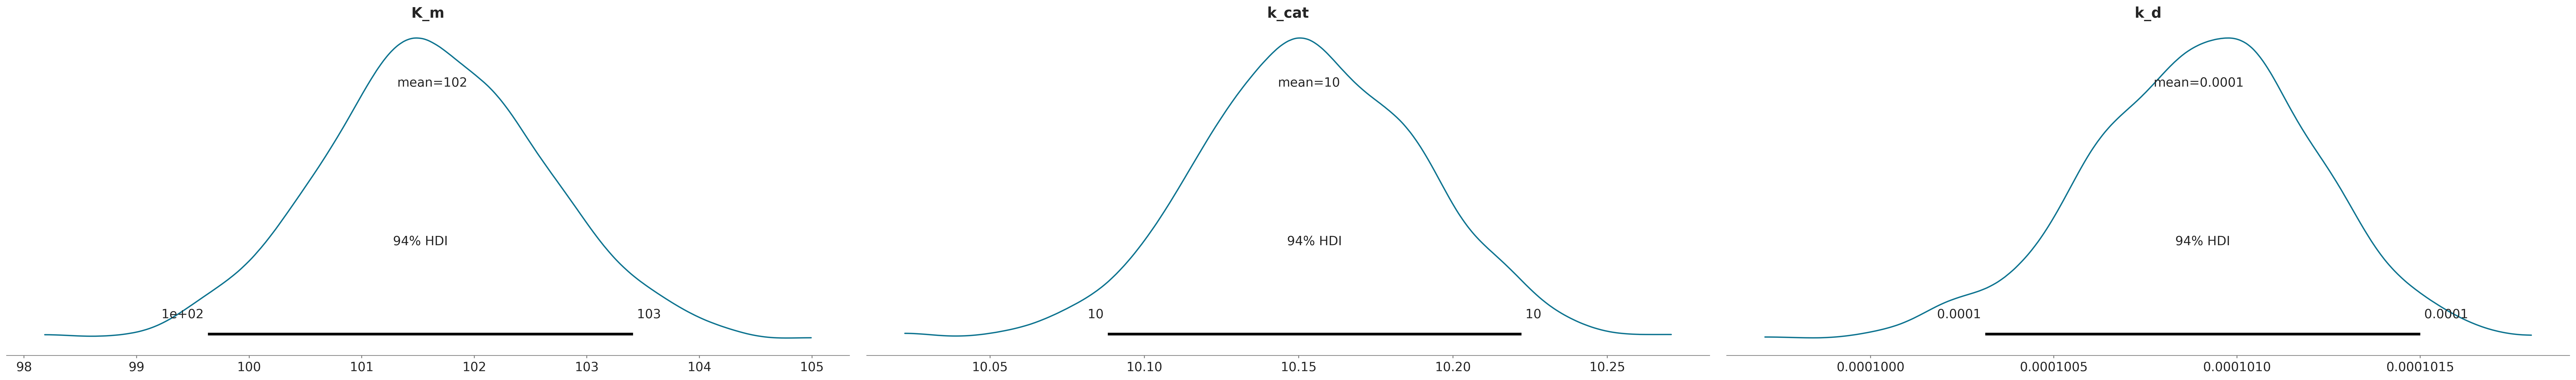

In [7]:
from catalax.mcmc import plot_posterior

plot_posterior(mcmc, model)

/Users/jara1991/anaconda3/envs/catalax/lib/python3.10/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(
/Users/jara1991/sysbiojax/catalax/mcmc/plotting.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


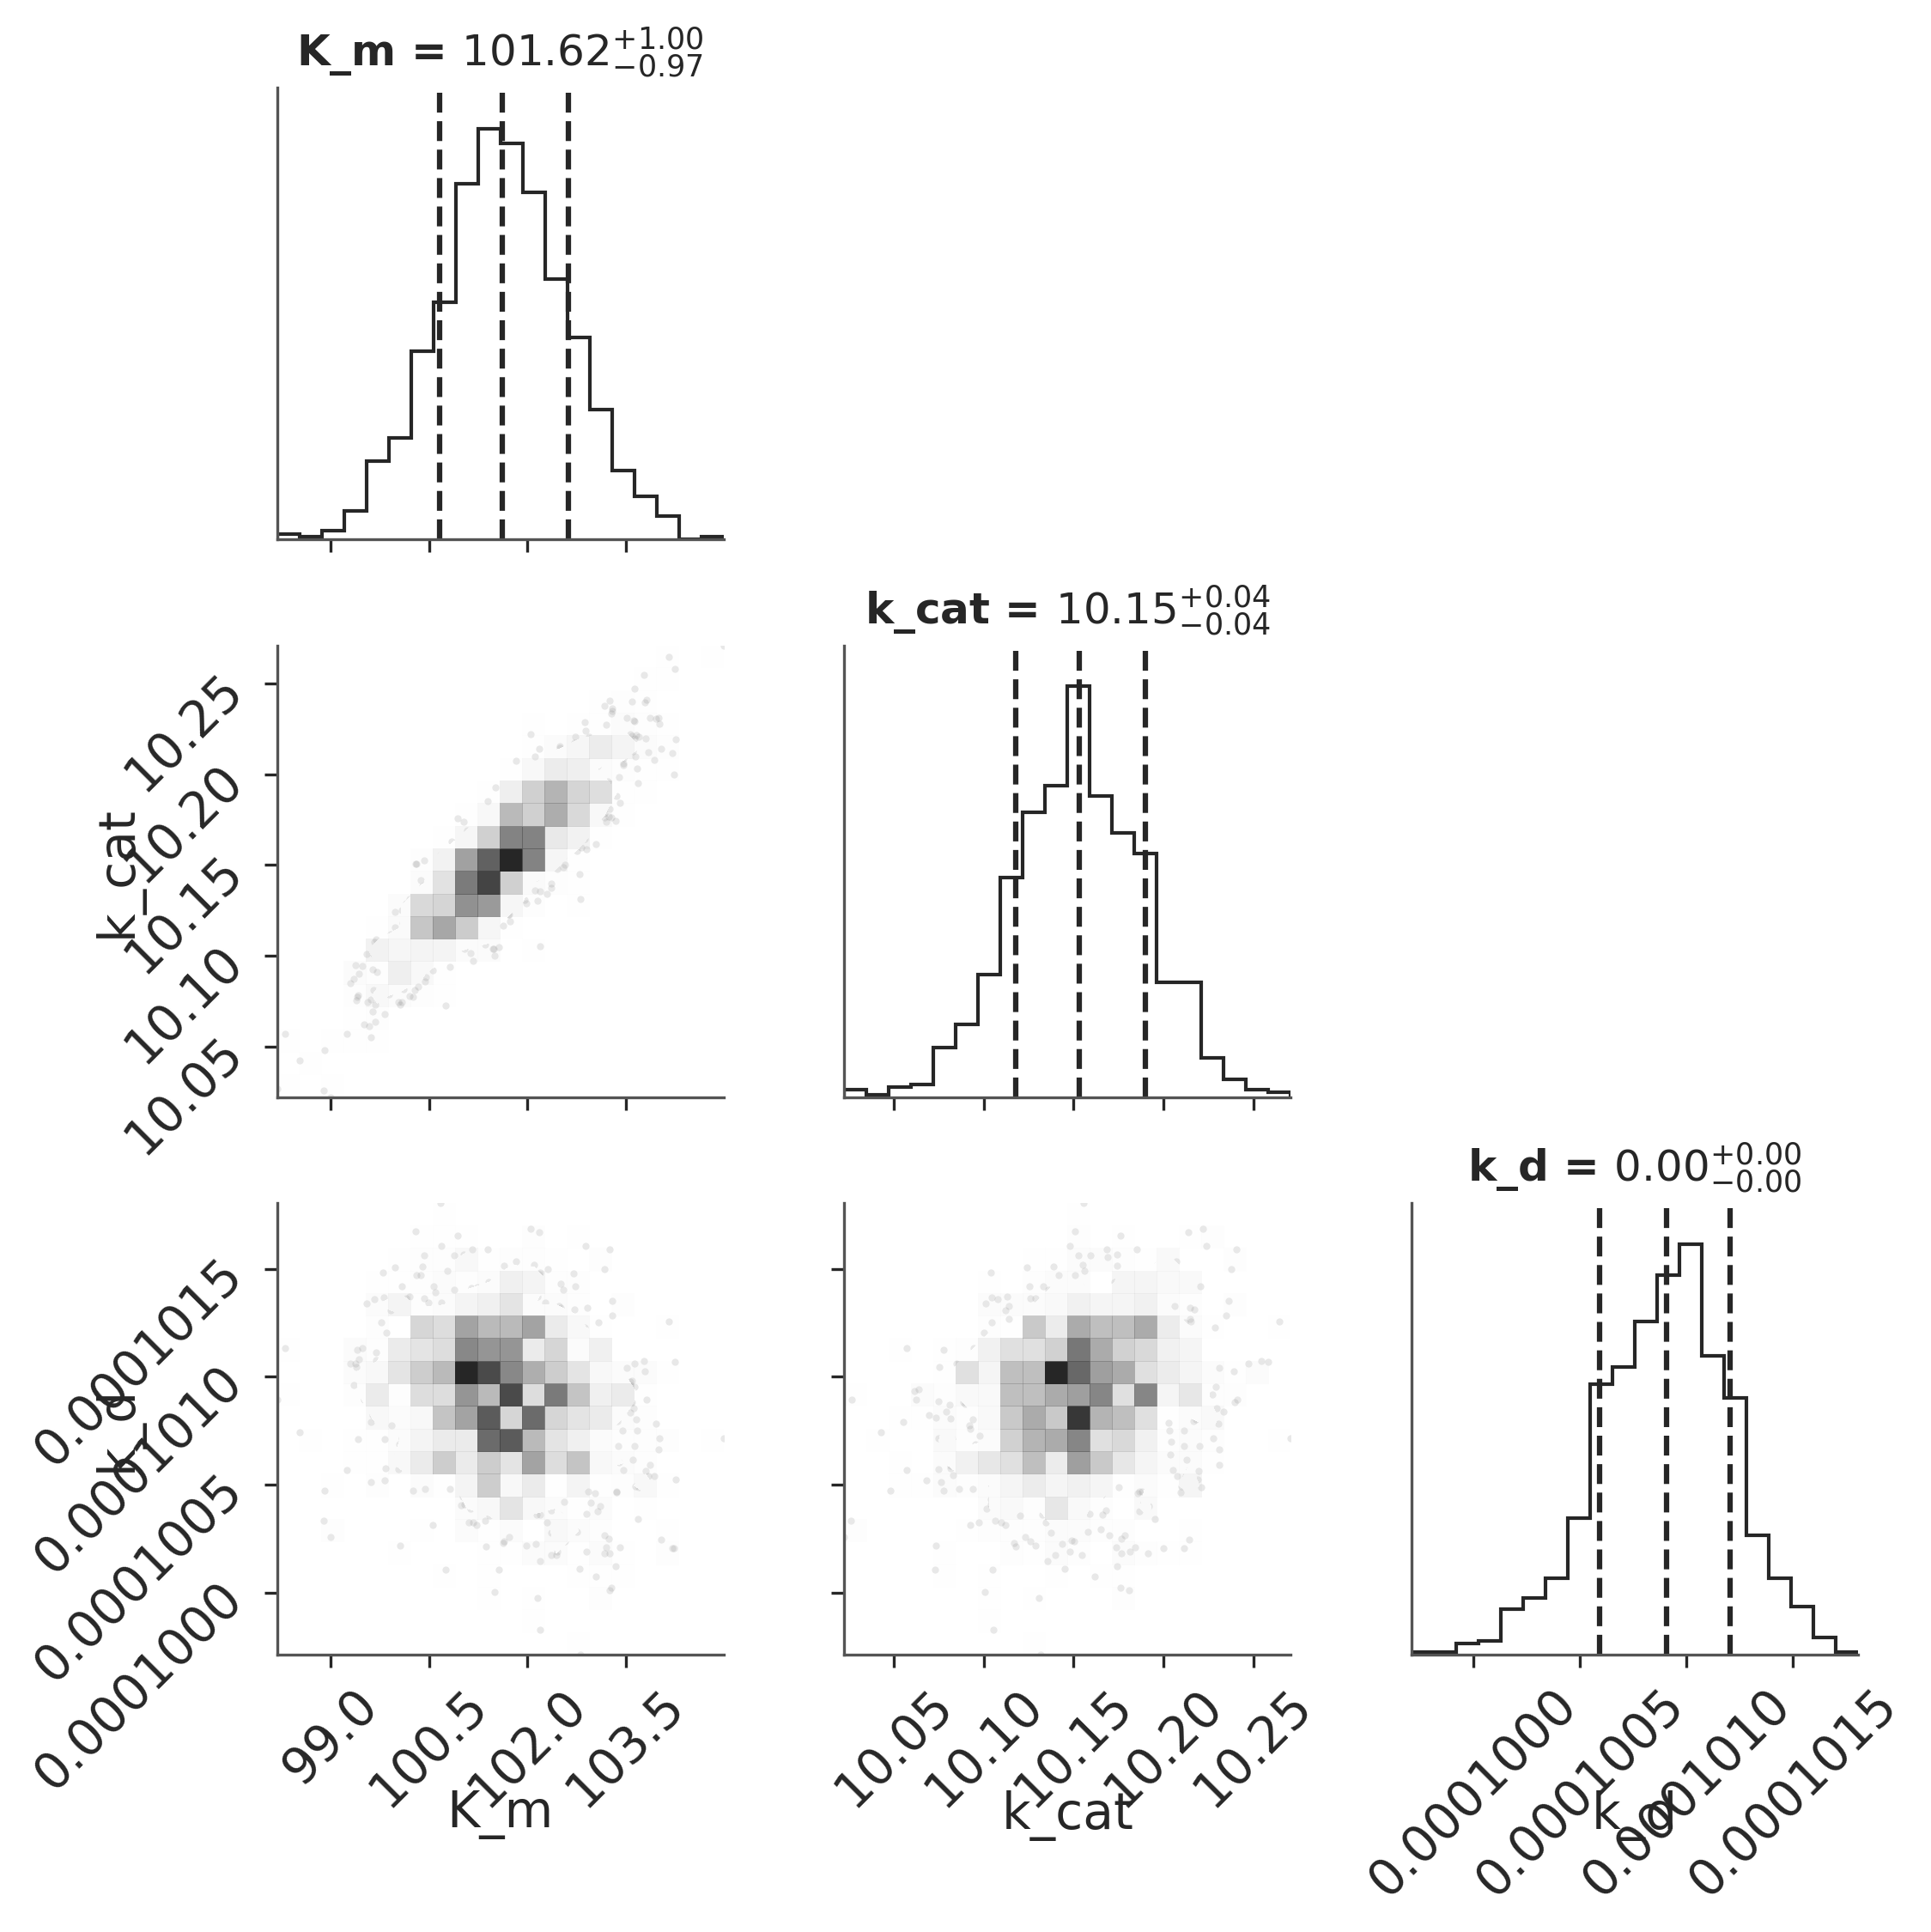

In [8]:
from catalax.mcmc import plot_corner

f = plot_corner(mcmc)